# Effective Groundwater Model Calibration

## Imports

In [1]:
import flopy
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Conceptual Model

![title](img/conceptual_model_1.png)

![title](img/conceptual_model_2.png)

![title](img/conceptual_model_3.png)

## Steady-State model setup 

We are creating a square model with:

* 2 layers
* 18 rows
* 18 columns
* GHB-Boundary (right side) 
* RIV-Boundary (left side)

### Set workspace for steady-state model

* and make shure that directory exists  
* save the starting path
* change to the working directory

In [2]:
workspace = os.path.join('steady-state')

if not os.path.exists(workspace):
    os.makedirs(workspace)
    
cwdpth = os.getcwd()

os.chdir(workspace)

### Create the MODFLOW model 
Store it (in this case in the variable `ml`, but you can call it whatever you want).  
The modelname will be the name given to all MODFLOW files (input and output).  
The exe_name should be the full path to your MODFLOW executable.  The version is either 'mf2k' for MODFLOW2000 or 'mf2005'for MODFLOW2005.

In [3]:
name = 'steady-state'

ml = flopy.modflow.Modflow(
    modelname=name, 
    exe_name='mf2005',
    version='mf2005'
)

### Discretization

We are defining all kind of discretization parameters.  

As we have a confining bed between top- and bottom-layer we have to specify  
the botm-parameter with three layer values `[50, 40, -10]` and set the   
laycbd-parameter with a flag (important: the flag must be 1) on the first layer `[1, 0]`




In [4]:
nlay = 2
nrow = ncol = 18
L = W = 18000
delr = L/nrow 
delc = W/ncol
top = 100
botm = [50, 40, -10]
laycbd = [1, 0]
itmuni = 1  # seconds

In [5]:
dis = flopy.modflow.ModflowDis(
    ml, 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol, 
    delr=delr,
    delc=delc, 
    top=top, 
    botm=botm, 
    laycbd=laycbd,
    itmuni=itmuni
)

### Boundaries

### BAS-Package 

Specify boundary conditions and starting heads. 

We can set one value for all cells.


In [6]:
ibound = 1
strt = 200

bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)

### RIV-Package 

The river boundary is located in the left side of the model and takes place in the upper layer.   

The river width is 10m and depth is 10m.

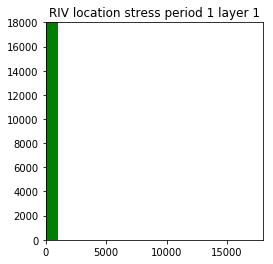

In [7]:
stage = 100
cond = 1000
rbot = 90

rivSp = {0: []}

for r in range(0, 18):
    rivSp[0].append([0, r, 0, stage, cond, rbot])
    
riv = flopy.modflow.ModflowRiv(ml, stress_period_data=rivSp)    

riv.plot(mflay=0)

### GHB-Package 

The general head boundary is located in the right side of the model and takes place in both layers.   

So we'll add two for loops, iterating through layers and rows

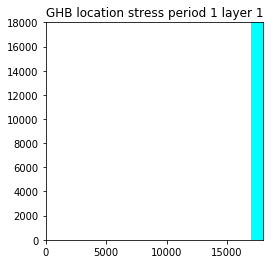

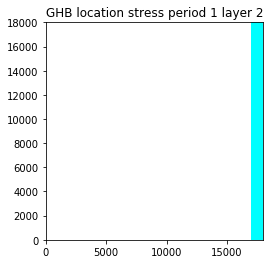

In [8]:
stage = 350
cond = 1E-7

ghbSp = {0: []}

for l in range(0, 2):
    for r in range(0, 18):
        ghbSp[0].append([l, r, 17, stage, cond])

ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghbSp)

ghb.plot()

### RCH-Package 

The recharge to the top layer is separated in two zones.

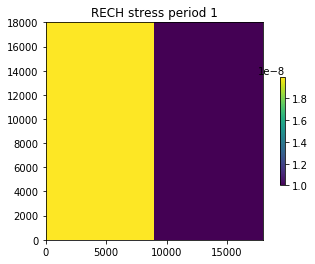

In [9]:
rchSp = {0: [[] for _ in range(nrow)]}

rchLeft = 2E-8
rchRight = 1E-8

for r in range(0, nrow):
    for c in range(0, ncol):
        if c < ncol/2:
            rchSp[0][r].append(rchLeft)
            continue
        
        rchSp[0][r].append(rchRight)

rch = flopy.modflow.ModflowRch(ml, rech=rchSp)

rch.plot()

### LPF-Package
The aquifer properties (really only the hydraulic conductivity) are defined with the LPF package.

In [10]:
hk = [3E-4, 4E-5]
vkcb = 1E-7
layvka = 1

lpf = flopy.modflow.ModflowLpf(ml, hk=hk, vkcb=vkcb, layvka=layvka)

### PCG-Package and OC-Package
Finally, we need to specify the solver we want to use (PCG with default values), and the output control (using the default values).  

Then we are ready to write all MODFLOW input files and run MODFLOW.

In [11]:
pcg = flopy.modflow.ModflowPcg(ml)
oc = flopy.modflow.ModflowOc(ml)

## Head observations

In [12]:
observations = [
    ['hd01', 0, 2, 0, 1.018040E+02],
    ['hd02', 0, 3, 3, 1.281170E+02],
    ['hd03', 0, 9, 8, 1.566780E+02],
    ['hd04', 0, 12, 3, 1.248930E+02],
    ['hd05', 0, 13, 5, 1.409610E+02],
    ['hd06', 1, 3, 3, 1.265370E+02],
    ['hd07', 1, 9, 0, 1.011120E+02],
    ['hd08', 1, 9, 8, 1.581350E+02],
    ['hd09', 1, 9, 17, 1.763740E+02],
    ['hd10', 1, 17, 5, 1.420200E+02],
]


obs = []

for o in observations:
    ho = flopy.modflow.HeadObservation(
        ml, 
        layer=o[1], 
        row=o[2], 
        column=o[3], 
        time_series_data=[[0,o[4]]]
    )
    
    obs.append(ho)

hob = flopy.modflow.ModflowHob(
    ml, 
    iuhobsv=1051, 
    hobdry=-9999.,
    obs_data=obs
)

### Write input and run the model

In [13]:
ml.write_input()
ml.run_model()

FloPy is using the following executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: steady-state.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/05/29 15:40:22

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/05/29 15:40:22
 Elapsed run time:  0.011 Seconds

  Normal termination of simulation


(True, [])

### Read the heads-file

In [14]:
os.chdir(cwdpth)
hds = flopy.utils.HeadFile(os.path.join(workspace, name + '.hds'))

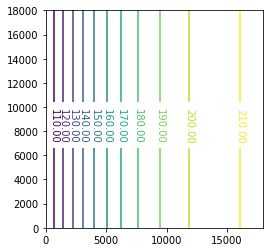

In [15]:
%matplotlib inline

h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, delr * nrow, nrow)

c = plt.contour(x, y, h[0], np.arange(100, 300, 10))
plt.clabel(c, fmt='%1.2f')
plt.axis('scaled')
plt.show()